In [35]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

In [36]:
df_train = pd.read_csv('/Users/dominicdebiaso/Development/datasets/allstate_train.csv',
                       index_col='id')
df_test = pd.read_csv('/Users/dominicdebiaso/Development/datasets/allstate_test.csv',
                      index_col='id')

### EDA

In [37]:
print(df_train.shape)
print(df_test.shape)

(188318, 131)
(125546, 130)


In [38]:
print("Feature difference btwn datasets",list(set(df_train.columns) - set(df_test.columns)))

('Feature difference btwn datasets', ['loss'])


In [39]:
df_train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
2,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
5,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
10,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
11,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [40]:
df_train.dtypes.value_counts()

object     116
float64     15
dtype: int64

In [41]:
df_train.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [42]:
print("Total missing values", df_train.isnull().sum().sum())

('Total missing values', 0)


### Analysis of Variables 

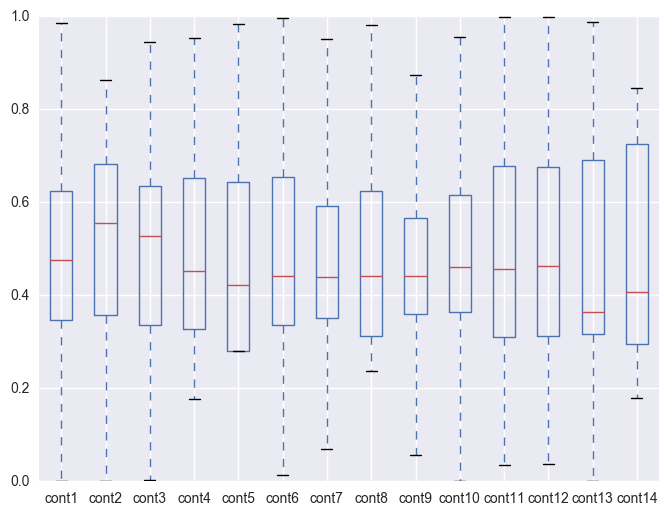

In [43]:
# Box plot of continuous variables
cont_vars = df_train.select_dtypes(include=['float64']).drop('loss', 1)
cont_vars.plot(kind='box', figsize=(8,6))

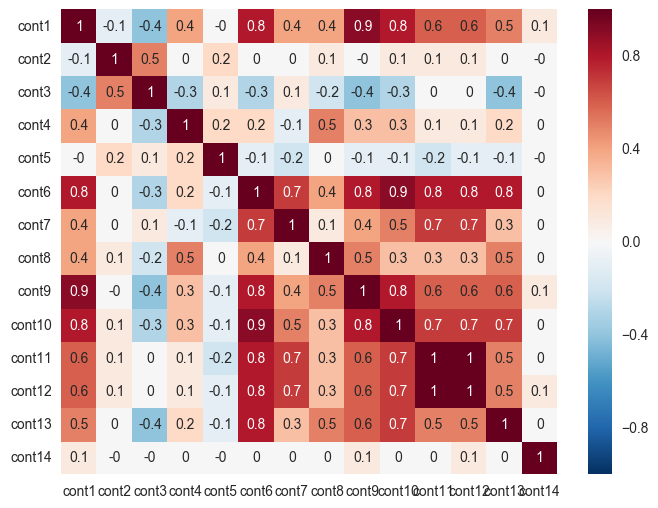

In [44]:
# Correlation between continuous variables 
plt.figure(figsize=(8,6))
sns.heatmap(cont_vars.corr().round(1), annot=True)

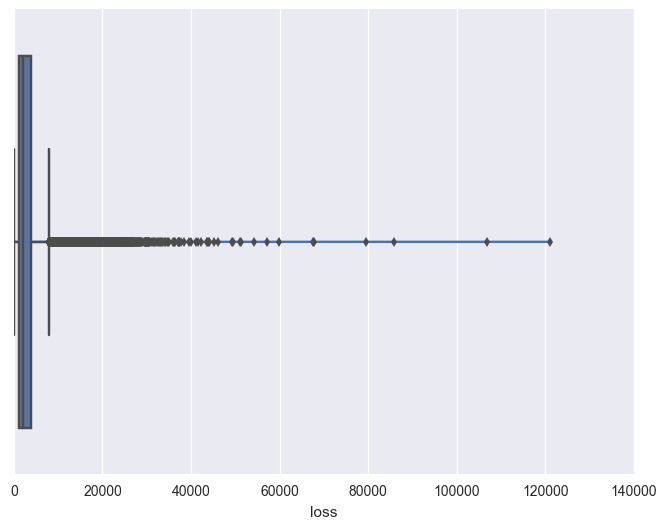

In [45]:
# Rightly skewed target, 'loss', variable
plt.figure(figsize=(8,6))
sns.distplot(df_train.loss)
sns.boxplot(df_train.loss)

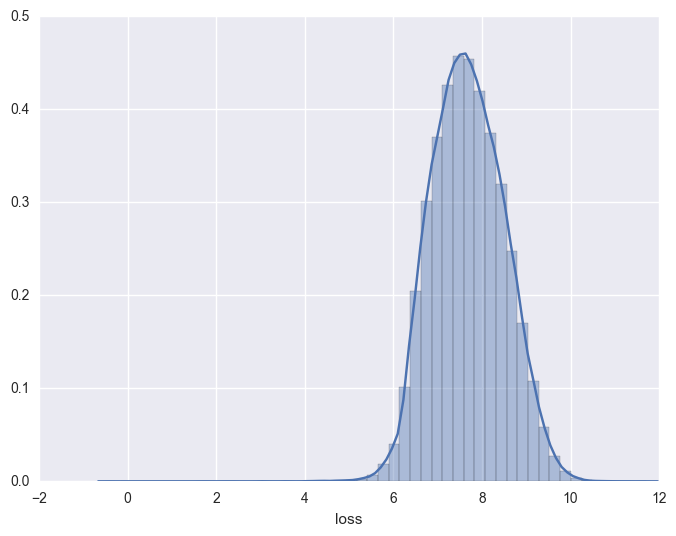

In [46]:
# Take the log of the target variable to get a normal distribution 
plt.figure(figsize=(8,6))
sns.distplot(np.log(df_train.loss))

In [ ]:
# Chi2
# scs.chi2_contingency(df_train.select_dtypes(include=['float64']))
# scs.chi2_contingency(pd.crosstab(df_train.cat10, df_train.cat12))

### Data Munging 

In [47]:
def preprocess_data(df):
    for cat_col in df.select_dtypes(include=['object']):
        df[cat_col] = pd.factorize(df[cat_col])[0]
    return df
train = preprocess_data(df_train)
X_train = train.iloc[:,:-1]
y_train = np.log(train.iloc[:,-1])
X_test = preprocess_data(df_test)

In [48]:
## Univariate Feature Importance
# F-test - compare significance of improvement of model with respect to variable additions with respect to the p-value
# Test the null hypothesis that there is no relationship btwn regressor and outcome
feature_importance = SelectKBest(score_func=f_regression, k=4)
feature_importance.fit(X_train, y_train)
sorted(zip(X_train.columns, feature_importance.scores_), key=lambda feats: feats[1], reverse=True)[0:4]

# For selecting only top "k" variables
# top_vars = feature_importance.transform(X_train)
# top_vars[0:5,:]

[('cat80', 34151.517205822463),
 ('cat12', 24044.034889746938),
 ('cat87', 18587.807919790866),
 ('cat10', 18446.243942451943)]

### ML 

In [ ]:
## Ridge Regression
# How to prevent overfitting:
# Both L1 and L2 regularization prevents overfitting by shrinking (imposing a penalty) on the coefficients.
# Difference between L1 and L2:
# L2 (Ridge) shrinks all the coefficient by the same proportions but eliminates none, while L1 (Lasso) 
# can shrink some coefficients to zero, performing variable selection.
# Which to use:
# If all the features are correlated with the label, ridge outperforms lasso, 
# as the coefficients are never zero in ridge. If only a subset of features are correlated with the label, 
# lasso outperforms ridge as in lasso model some coefficient can be shrunken to zero.
# Source: https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization

l2_reg = Ridge()
param_grid = {
    'alpha':[0.01, 1, 10, 100] #larger values correspond to stronger regularization thus reducing overfitting
}
grid = GridSearchCV(l2_reg, param_grid, cv=10, scoring='neg_mean_absolute_error') #MAE-neg oriented; lower is better
%time grid.fit(X_train, y_train)

print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)

y_pred = grid.predict(X_test)
df_l2_reg = pd.DataFrame(np.exp(y_pred), index=X_test.index, columns=['loss']) #took the log of y_train so need to do the exp of y_test
# df_l2_reg.to_csv('/Users/dominicdebiaso/Desktop/kaggle_allstate_l2_reg.csv')

In [ ]:
## Linear Support Vector Regression

ln_svr = LinearSVR()
param_grid = {
    'epsilon':np.arange(0,1,0.3).tolist(),
    'C':[0.01, 1, 10],                #larger parameter means less regularization is used
    'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'] #L1 vs L2, respectively
}
grid = GridSearchCV(ln_svr, param_grid, cv=5, n_jobs=2, scoring='neg_mean_absolute_error')
%time grid.fit(X_train, y_train)

print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)

y_pred = grid.predict(X_test)
df_ln_svr = pd.DataFrame(np.exp(y_pred), index=X_test.index, columns=['loss'])
# df_ln_svr.to_csv('/Users/dominicdebiaso/Desktop/kaggle_allstate_ln_svr.csv')

In [ ]:
## XGBoost
# Use scikit's xbg implementation to gridsearch
cv_params = {
    'learning_rate':np.arange(0.01,0.2,0.0.05).tolist(), 
    'gamma':[0,1], 
    'max_depth':[3,7,10], 
    'min_child_weight':[1,6],
    'subsample':[0.5,0.7,1],
    'colsample_bytree':[0.5,0.7,1]
}

ind_params = {
    'silent':1,
    'n_estimators':200,
    'objective':'reg:linear'
}
grid = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
%time grid.fit(X_train, y_train)

print 'Grid best score:', (grid.best_score_)
print 'Grid best parameters:', (grid.best_params_)

In [33]:
# Use DMatrix once parameters have been chosen
# Use XGBoost built-in CV
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

param = {
    # General
    'silent':1,
    # Booster
    'eta':0.06,
    'gamma':1,
    'max_depth':7,
    'min_child_weight':6,
    'subsample':0.7,
    'colsample_bytree':0.7,
    # Learning
    'objective':'reg:linear',
    'eval_metric':'mae'
}

xgb_cv = xgb.cv(param, dtrain, num_boost_round=3000, nfold=5, metrics=['mae'],
                early_stopping_rounds=100) #don't improve accuracy for at least 100 new trees
best_nrounds = xgb_cv.shape[0]

In [34]:
# Finally train on our final model
bst = xgb.train(param, dtrain, num_boost_round=best_nrounds)
preds = bst.predict(dtest)

df_xgb = pd.DataFrame(np.exp(preds), index=X_test.index, columns=['loss'])
# df_xgb.to_csv('/Users/dominicdebiaso/Desktop/kaggle_allstate_xgb.csv')

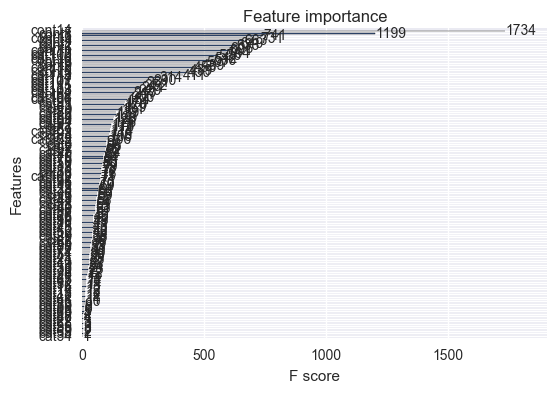

In [20]:
xgb.plot_importance(bst)

In [32]:
sorted(bst.get_fscore().items(), key=lambda x: x[1], reverse=True)[:4]

[('cont14', 1734), ('cont7', 1199), ('cont8', 741), ('cont13', 731)]